In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [11]:
data = pd.read_csv("../Merging/Merged_Data.csv")
print(data.columns)
data.head(5)

Index(['period', 'plantCode', 'plantName', 'fuel2002', 'fuelTypeDescription',
       'state', 'stateDescription', 'primeMover', 'total-consumption',
       'total-consumption-units', 'total-consumption-btu', 'generation',
       'gross-generation', 'consumption-for-eg', 'consumption-for-eg-units',
       'consumption-for-eg-btu', 'average-heat-content',
       'average-heat-content-units', 'total-consumption-btu-units',
       'generation-units', 'gross-generation-units',
       'consumption-for-eg-btu-units', 'X', 'Y', 'FID', 'OBJECTID',
       'Plant_Code', 'Plant_Name', 'Utility_ID', 'Utility_Na', 'sector_nam',
       'Street_Add', 'City', 'County', 'State', 'Zip', 'PrimSource',
       'source_des', 'tech_desc', 'Install_MW', 'Total_MW', 'Bat_MW', 'Bio_MW',
       'Coal_MW', 'Geo_MW', 'Hydro_MW', 'HydroPS_MW', 'NG_MW', 'Nuclear_MW',
       'Crude_MW', 'Solar_MW', 'Wind_MW', 'Other_MW', 'Source', 'Period',
       'Longitude', 'Latitude', 'LATITUDE', 'LONGITUDE', 'DATE', 'ELEVATION',


,period,plantCode,plantName,fuel2002,fuelTypeDescription,state,stateDescription,primeMover,total-consumption,total-consumption-units,...,TEMPEXT_BASE40,TEMPEXT_BASE45,TEMPEXT_BASE50,OVER_60,OVER_70,OVER_80,UNDER_40,UNDER_30,UNDER_20,SUM_OVER_UNDER
0,2020-01-01,57950,MSC Croswell,NG,Natural Gas,MI,Michigan,ALL,84432,MMBtu per Mcf,...,23.723333,18.723333,14.123333,0.600000,0.300000,0.0,0.0,0.0,0.0,0.900000
1,2020-12-01,57950,MSC Croswell,NG,Natural Gas,MI,Michigan,ALL,11343,MMBtu per Mcf,...,17.293548,12.487097,8.706452,0.354839,0.032258,0.0,0.0,0.0,0.0,0.387097
2,2023-08-01,57950,MSC Croswell,NG,Natural Gas,MI,Michigan,ALL,109965,MMBtu per Mcf,...,46.403226,41.403226,36.403226,1.000000,1.000000,1.0,0.0,0.0,0.0,3.000000
3,2023-04-01,57950,MSC Croswell,NG,Natural Gas,MI,Michigan,ALL,12548,MMBtu per Mcf,...,32.903333,27.903333,22.903333,1.000000,0.833333,0.0,0.0,0.0,0.0,1.833333
4,2023-02-01,57950,MSC Croswell,NG,Natural Gas,MI,Michigan,ALL,96587,MMBtu per Mcf,...,25.867857,20.867857,15.867857,0.785714,0.357143,0.0,0.0,0.0,0.0,1.142857


In [12]:
# Load cluster labels
with open('Norm_Plant_Clusters.p', 'rb') as f:
    cluster_labels = pickle.load(f)

print(cluster_labels)

{'N_KM2':      N_plantCode  N_KM2_0  N_KM2_1
0              9      0.0      1.0
1             99      0.0      1.0
2            136      1.0      0.0
3            298      1.0      0.0
4            550      0.0      1.0
..           ...      ...      ...
478        66596      1.0      0.0
479        66597      1.0      0.0
480        66612      1.0      0.0
481        66613      1.0      0.0
482        66614      1.0      0.0

[483 rows x 3 columns], 'N_H2':      N_plantCode  N_H2_0  N_H2_1
0              9     1.0     0.0
1             99     1.0     0.0
2            136     1.0     0.0
3            298     1.0     0.0
4            550     1.0     0.0
..           ...     ...     ...
478        66596     1.0     0.0
479        66597     1.0     0.0
480        66612     1.0     0.0
481        66613     1.0     0.0
482        66614     1.0     0.0

[483 rows x 3 columns], 'N_KM3':      N_plantCode  N_KM3_0  N_KM3_1  N_KM3_2
0              9      0.0      0.0      1.0
1             99   

In [13]:
# Define the time periods and features for training and testing
start_train = '2019-01-01'
end_train = '2022-12-31'
start_test = '2023-01-01'
end_test = '2023-12-31'
model_features = ['ELEVATION', 'TEMP',
       'WDSP', 'MXSPD', 'GUST', 'MAX', 'MIN', 'PRCP', 'SNDP','TEMPEXT_BASE40', 'TEMPEXT_BASE45', 'TEMPEXT_BASE50', 
       'OVER_60', 'OVER_70', 'OVER_80', 'UNDER_40', 'UNDER_30', 'UNDER_20',
       'SUM_OVER_UNDER', 'LATITUDE','LONGITUDE','Zip','plantCode']
# add feature for distance to weather station from power plant?


In [14]:

data['period'] = pd.to_datetime(data['period'])
data.sort_values(by='period', inplace=True)
plant_codes = data['plantCode'].unique()
data = data[data['period'] >= '2019-01-01']

# Exclude negative consumption values
data = data[data['total-consumption'] > 0]

# Convert 'state' column to categorical type
data['state'] = data['state'].astype('category')
    
# Extract features and target variable
X = data[model_features]
y = data['total-consumption']

# Filter the data for training and testing
train_data = data[(data['period'] >= start_train) & (data['period'] <= end_train)]
test_data = data[(data['period'] >= start_test) & (data['period'] <= end_test)]

# Extract features and target variable for training
X_train = train_data[model_features]
y_train = train_data['total-consumption']

# Extract features and target variable for testing
X_test = test_data[model_features]
y_test = test_data['total-consumption']

In [34]:
# How to do cross validation folds? Feature ablation
# For cross validation: could do (4 different folds, increasing data (year 1, year 1-2, year 1-3, year 1-4))

def train_and_evaluate_with_clusters(cluster_labels, model, start_train, end_train, start_test, end_test, model_features, data):
    results = []
    for key, clusters_df in cluster_labels.items():
        # Convert cluster labels into one-hot encoded features
        def cluster_to_one_hot(data, clusters):
            one_hot_clusters = pd.get_dummies(clusters)
            merged_data = pd.merge(data, one_hot_clusters, how='left', left_on='plantCode', right_on='N_plantCode')
            merged_data.drop(columns=['N_plantCode'], inplace=True)  # Drop the redundant plant code column from clusters
            return merged_data
        
        X_with_clusters_train = cluster_to_one_hot(X_train.copy(), clusters_df)
        X_with_clusters_test = cluster_to_one_hot(X_test.copy(), clusters_df)
        
        # Get all features used in the model
        all_features = X_with_clusters_train.columns.tolist()
        
        # Fit the model on the training data
        model.fit(X_with_clusters_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_with_clusters_test)

        # Evaluate the model
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Print out all features
        #print(f'Features used in model with cluster combo "{key}":')
        #for feature in all_features:
        #    print(feature)

        results.append({'Cluster Combo': key, 'Mean Squared Error': mse, 'R-squared': r2, 'Features': all_features})

    results_df = pd.DataFrame(results)
    print(results_df)


In [35]:
# Define the number of trees in the forest
n_estimators = 100  # Example number of trees, you can change it as needed

# Create a Random Forest model
rf_model = RandomForestRegressor(n_estimators=n_estimators)

# Call the function with the model and other parameters
train_and_evaluate_with_clusters(cluster_labels, rf_model, start_train, end_train, start_test, end_test, model_features, data)

C:\Users\nicoesse\AppData\Local\Temp\ipykernel_42848\276433868.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['state'] = data['state'].astype('category')


Model evaluation:
Mean Squared Error: 409557396996.85583
R-squared: 0.8558758987990294


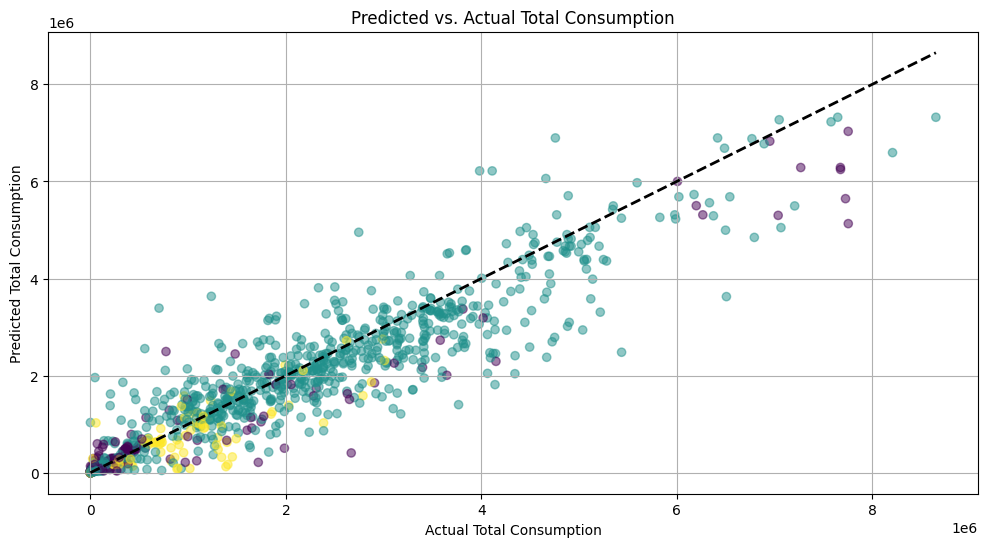

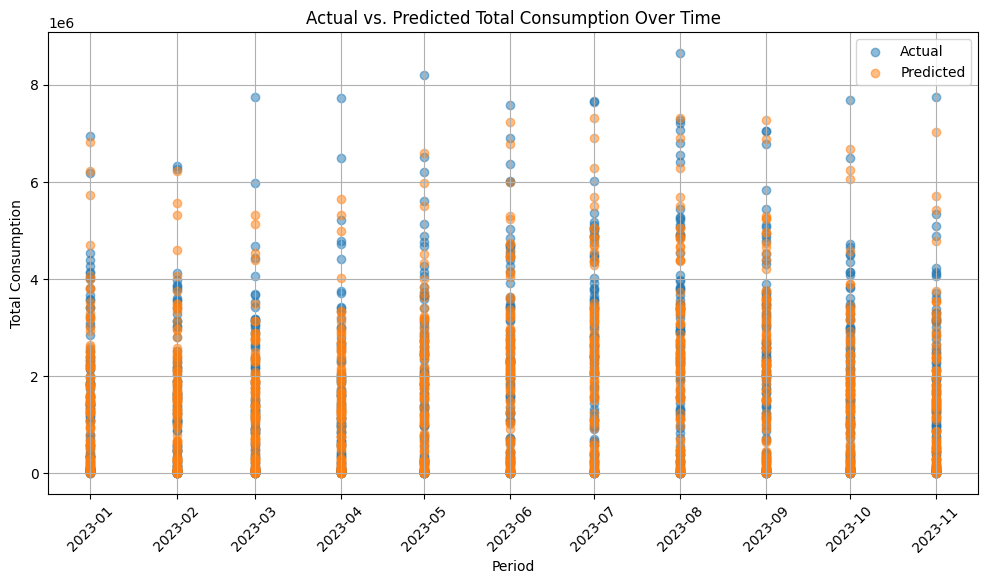

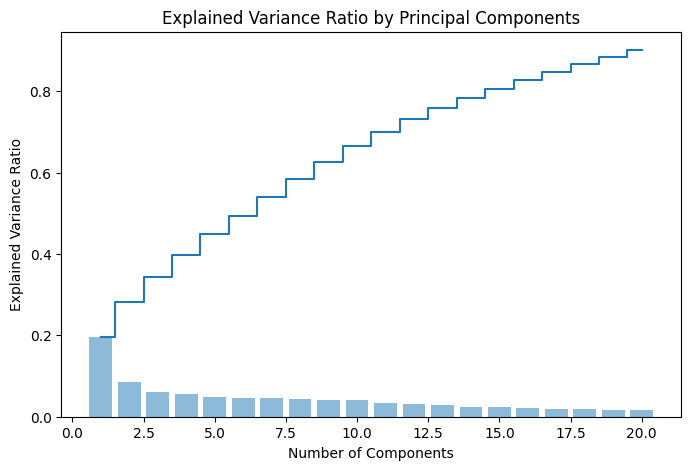

In [32]:
knn_model = KNeighborsRegressor(n_neighbors=5)

# Call the train_test_and_plot function
train_and_evaluate_with_clusters(cluster_labels, knn_model, start_train, end_train, start_test, end_test, model_features, data)


C:\Users\nicoesse\AppData\Local\Temp\ipykernel_42848\276433868.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['state'] = data['state'].astype('category')


Model evaluation:
Mean Squared Error: 726560810293.8728
R-squared: 0.7443217372722554


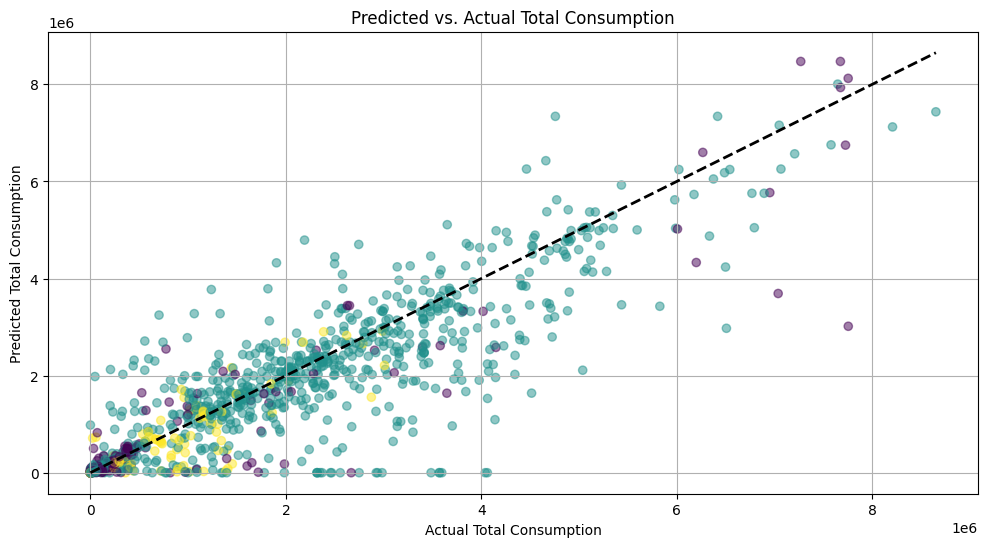

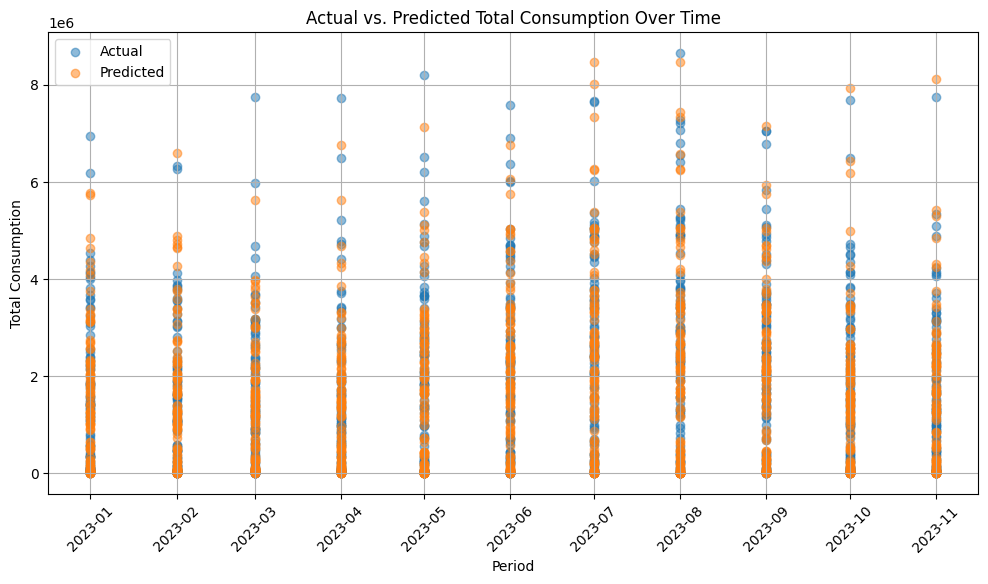

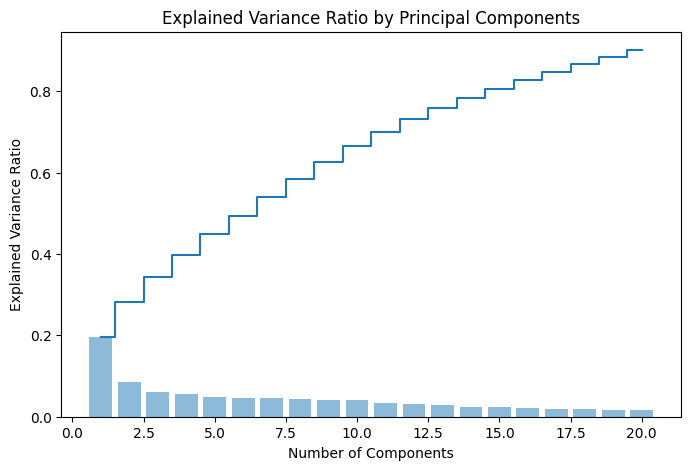

In [33]:
nb_model = GaussianNB()
train_test_and_plot(data, nb_model, start_train, end_train, start_test, end_test, model_features)
